# Leader - Policy-Gradient Based

In this notebook, we develop a policy-gradient based leader agent. The leader learns a policy to lead followers via a target zone to gather more apples. We modify the Crossing environment so that it recognizes multiple roles in a team of agents - leader and followers.

We discover that tradition RL (based on policy-gradient and Q-learning) has severe limitations in strategic decision making. Both the follower agents with partial observation of the game space as well as leader agent with complete observation of the game space find it hard to overcome the problems of local optima and sparce reward.

<img src="images/Leader_PG.png" width="600">

Specifically, even though a much larger food pile exist on the right side of the river, both the leader agent and the follower agents remain fixated on the smaller food pile on the left side of the river closer to them. They fail completely to recognize the strategic fact that there is not enough apples in this smaller pile for the large number of agents competing for it. 

In [1]:
import os
import random
import time
import platform
import torch
import torch.optim as optim
import gym
import numpy as np
import pickle

# This is the Crossing game environment
from xteams_env import CrossingEnv
from xteams_model3 import *
from interface import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


# Scenarios

The agent models stored in various folders have been trained under different training scenarios based on:
* team organization: 1 team of 10 agents, 2 teams of 5 agents
* team roles: leader and followers, followers only
* starting temps
* team cultures: pacifist, cooperative
* num of game steps per episode: 300, 600, 1200
* leader reward: number of apples in the target zone, team reward gathered

## 1 team of 10 Pacifist agents 

### map = food_d37

| Scenario |      Temp     |  Game Steps |
|----------|---------|------|
| 1 |  0.4 | 300 |
| 2 |  0.8 | 300 |
| 3 |  1.0 | 300 |
| 4 |  1.0 | 600 |
| 5 |  1.25 | 300 |
| 6 |  1.25 | 600 |
| 7 |  1.5 | 300 |
| 8 |  1.5 | 600 |
| 9 |  1.5 | 1200 |
| 10 |  2.0 | 300 |
| 11 |  2.0 | 600 |
| 12 |  2.0 | 1200 |
| 13 |  4.0 | 300 |
| 14 |  4.0 | 600 |
| 15 |  4.0 | 1200 |
| 16 |  8.0 | 300 |
| 17 |  8.0 | 600 |
| 18 |  8.0 | 1200 |

### map = food_d37_river_w1_d25

| Scenario |      Temp     |  Game Steps |
|----------|---------|------|
| 19 |  1.0 | 300 |
| 20 |  1.25 | 300 |
| 21 |  2.0 | 300 |
| 22 |  4.0 | 300 |

## 2 team of 5 agents each 

### No Leader in both teams (Start Temp = 1.25; Game Steps/Episode = 300)

| Scenario | Cultures | Map  |
|------|------|------|
| 23 | Pac vs Pac  | food_d37 |
| 24 | Pac vs Coop | food_d37_river_w1_d25 |
| 25 | Pac vs Coop | food_d37_river_w1_d25 |


### Team 1 (Leader + Followers) Team 2 (Leader-less)

| Scenario | Temp | Cultures | Map  | Leader type | Leader Metric |
|------|------|------|------|------|------|
| 26 | 1.25 | Pac vs Coop  | food_d37_river_w1_d25 | crawler | team_reward |
| 27 | 2.0 | Pac vs Coop | food_d37_river_w1_d25 | crawler | team_reward |
| 28 | 1.5 | Pac vs Coop | food_d37_river_w1_d25 | drone | team_reward |
| 29 | 1.5 | Pac vs Pac  | food_d37_river_w1_d25 | drone | team_reward |
| 30 | 2.0 | Pac vs Pac  | food_d37_river_w1_d25 | drone | team_reward |
| 31 | 2.0 | Pac vs Pac  | food_d37_river_w1_d25 | drone | apples |
| 32 | 2.0 | Pac vs Pac  | food_d37_river_w1_d25 | drone | apples + team_reward |


In [2]:
folders = [
    # Agents trained in map = food_d37
    'models/1T-10L/baseline/food_d37/pacifist/t0.4_rp-1.0_300gs/',   # scenario=1
    'models/1T-10L/baseline/food_d37/pacifist/t0.8_rp-1.0_300gs/',   # scenario=2
    'models/1T-10L/baseline/food_d37/pacifist/t1.0_rp-1.0_300gs/',   # scenario=3
    'models/1T-10L/baseline/food_d37/pacifist/t1.0_rp-1.0_600gs/',   # scenario=4
    'models/1T-10L/baseline/food_d37/pacifist/t1.25_rp-1.0_300gs/',   # scenario=5
    'models/1T-10L/baseline/food_d37/pacifist/t1.25_rp-1.0_600gs/',   # scenario=6
    'models/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_300gs/',   # scenario=7
    'models/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_600gs/',   # scenario=8
    'models/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_1200gs/',   # scenario=9
    'models/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_300gs/',   # scenario=10
    'models/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_600gs/',   # scenario=11
    'models/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_1200gs/',   # scenario=12
    'models/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_300gs/',   # scenario=13
    'models/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_600gs/',   # scenario=14
    'models/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_1200gs/',   # scenario=15
    'models/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_300gs/',   # scenario=16
    'models/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_600gs/',   # scenario=17
    'models/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_1200gs/',   # scenario=18

    # Agents trained in map = food_d37_river_w1_d25
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.0_rp-1.0_300gs/",   # scenario=19
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.25_rp-1.0_300gs/",   # scenario=20 
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t2.0_rp-1.0_300gs/",   # scenario=21
    "models/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t4.0_rp-1.0_300gs/",   # scenario=22
    
    # 2 Teams of 5 Agents trained in map = food_d37
    "models/2T-5L/baseline/food_d37/pacifist/t1.25_rp-1.0_300gs/",     # scenario=23
    "models/2T-5L/baseline/food_d37/pac_vs_coop/t1.25_rp-1.0_300gs/",   # scenario=24
    
    # 2 Teams of 5 Agents trained in map = food_d37_river_w1_d25
    # Team Viking (Pacifist w/o leader) vs Team Frank (Cooperative)
    "models/2T-5L/baseline/food_d37_river_w1_d25/pac_vs_coop/t1.25_rp-1.0_300gs/",   # scenario=25
    
    # Team Viking (Pacifist w/ leader) vs Team Frank (No Leader)
    "models/2T-5L/pac_leader/food_d37_river_w1_d25/pac_vs_coop/t1.25_rp-1.0_300gs/", # scenario=26
    "models/2T-5L/pac_leader/food_d37_river_w1_d25/pac_vs_coop/t2.0_rp-1.0_300gs/",   # scenario=27
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_coop/t1.5_rp-1.0_300gs/",   # scenario=28
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t1.5_rp-1.0_300gs/",   # scenario=29 
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t2.0_rp-1.0_300gs/",   # scenario=30  
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples/t2.0_rp-1.0_300gs/",   # scenario=31
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples_teamreward/t2.0_rp-1.0_300gs/"   # scenario=32
    
]

# Parameter sets pertaining to the trained models in the folders above (not used in the code)
parameters =[ 
        # Temperature for explore/exploit; penalty per step in river; game steps per episode
    
        # 1 Team of 10 Agents trained in map = food_d37
            {'temp_start':0.4, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':0.8, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':600},    
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':600},    
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':1200},
    
        # 1 Team of 10 Agents trained in map = food_d37_river_w1_d25    
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':300},
    
        # 2 Teams of 5 Agents trained in map = food_d37
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
    
        # 2 Teams of 5 Agents trained in map = food_d37_river_w1_d25
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
    
        # 2 Teams of 5 Agents trained in map = food_d37_river_w1_d25
        # Team Viking (Pacifist w/ leader) vs Team Frank (Cooperative)
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},    
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},   
            {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300} 
            ]

print (len(parameters))
print (len(folders))

32
32


# Teams + Agents --> Env

The new Crossing environment accepts a list of parameters of the participating agents and teams.

**Team parameters**
* name - name of team
* color - color of the team (can be over-ridden by agent colors)
* culture - use to calculate and dole out team rewards to agents during training
* roles - a list of possible roles in the team
* target_zone - an area where agents are rewarded to assemble within
* banned_zone - an area where agents are penalized for staying within

**Agent parameters**
* id - id of the agent
* team - the team the agent is attached to
* color - color of the agent when rendering (can over-ride default team color
* type - 'crawler' or 'drone' - affecting the agent's policy NN, action and obs spaces
* role - the agent's role in the team

The code below plays a game using the new environment using Agents previously trained in Crossing_Baseline. Agent 0 of Team Viking has the 'leader' role. 

If an agent is a 'leader', the Environment sets the target_zone for its team based on the agent's location. During rendering, the target zone is represented by a green box.  

In [17]:
from torch.autograd import Variable

game = 'Crossing'
maps = [
    "food_d37_river_w1_d25",
    "food_d37_river_w1_d25_v2",
    "food_d37_river_w1_d25_v3",
    "food_d37_river_w1_d25_v4",
]
starts = [
    (3,9),
    (3,18),
    (20,9),
    (20,18),
    (50,9),
    (50,18),
]

droneleader_start = starts[random.randint(0,len(starts)-1)]
map_name = maps[random.randint(0,len(maps)-1)]

print("Drone starts at {} in map {}.".format(droneleader_start, map_name))

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 31
dir_name = folders[scenario-1]
parameter = parameters[scenario-1]
episodes = 2000  # This is used to recall a model file trained to a # of episodes

# There will be 10 agents - 0 teams of 0 AI agents each and 0 random agent
num_ai_agents = 10
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

# Scenario 26-32
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},        
        {'name': 'Franks', 'color': 'red',
         'culture': {'name':'pacifist','laser_penalty':-1.0},
         # 'culture': {'name':'cooperative','coop_factor':5.0},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None}
]

"""
# Scenario 1-25
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist','laser_penalty':-1.0},
         # 'culture': {'name':'cooperative','coop_factor':5.0},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
        {'name': 'Franks', 'color': 'red',
         'culture': {'name':'pacifist','laser_penalty':-1.0},
         # 'culture': {'name':'cooperative','coop_factor':5.0},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None}
]
"""


agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',     \
         'role': 'follower', 'start': (1,7)},  # Use a different color for Leader
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9)},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8)},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7)},
        # Leader of Team Viking is a drone and has a different color
        {'id': 4, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': droneleader_start},
        # Leader of Team Viking is a crawler and has a different color
        #{'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
        # 'role': 'follower', 'start': (3,9)},
    
        {'id': 5, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,1)},
        {'id': 6, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,3)},
        {'id': 7, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,2)},
        {'id': 8, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,1)},
        {'id': 9, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,3)}
]

# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 300

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_ai_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
if episodes > 0:
    agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA{}_{}_ep{}.p'.format(i,game,episodes)
        try:
            with open(model_file, 'rb') as f:
                
                print("Load saved model for agent {}".format(i))
                
                # Load agent policy based on type
                if agents_params[i]['type'] is 'crawler':
                    agent = Crawler_Policy(num_frames, num_crawler_actions, 0)
                elif agents_params[i]['type'] is 'drone':
                    agent = Drone_Policy(num_frames, num_drone_actions, 0)
                else:
                    raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                optimizer = optim.Adam(agent.parameters(), lr=0.1)

                # New way to save and load models - based on: 
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                _ = load_model(agent, optimizer, f, device=device)
                agent.eval()
                agents[i] = agent
        except OSError:
            print('Model file not found.')
            raise
else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load AI agent {}".format(i))
        if agents_params[i]['type'] is 'drone':
            agents.append(Drone_Policy(num_frames, num_drone_actions, i))
        elif agents_params[i]['type'] is 'crawler':
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
        else:
            raise Exception('Invalid type for agent {}: {}'.format(i,agents_params[i]['type']))

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load random agent {}".format(i))
    agents.append(Rdn_Policy())

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0], agents[1], agents[2], agents[3], agents[4]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:5]]))
# Team Franks
teams.append(Team(name=teams_params[1]['name'],color=teams_params[1]['color'],   \
                  culture=teams_params[1]['culture'], roles=teams_params[1]['roles'], \
                  agent_policies=[agents[5], agents[6], agents[7], agents[8], agents[9]], \
                  agent_roles = [agent['role'] for agent in agents_params[5:10]]))

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_agent=0)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i in range(num_ai_agents):    # For AI agents
            actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_ai_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        for i in range(num_agents):
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
        total = 0
        for i in range(num_ai_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i in range(num_ai_agents):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agents_params[i]['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/frame))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        print('US agents hit = {}'.format(agent_US_hits))
        print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nStatistics in Aggregate')
print ('=======================')
print ('Total rewards gathered = {}'.format(total_rewards))
print ('Av. rewards per agent = {0:.2f}'.format(total_rewards/num_ai_agents))
print ('Num laser fired = {}'.format(total_tags))
print ('Total US Hit (friendly fire) = {}'.format(total_US_hits))
print ('Total THEM Hit = {}'.format(total_THEM_hits))
print ('friendly fire (%) = {0:.3f}'.format(total_US_hits/(total_US_hits+total_THEM_hits+1e-7)))

for (i, loc) in env.consumption:
    if loc[0] > second_pile_x:
        # print ('agent {} gathered an apple in 2nd pile'.format(i))
        crossed[i] = 1
        
print ("Num agents gathering from 2nd food pile: {}".format(sum(crossed)))

print ('\nStatistics by Team')
print ('===================')
top_team = None
top_team_reward = 0

for i, team in enumerate(teams):
    if team.name is not 'Crazies':
        reward = sum(team.sum_rewards())
        print ('Team {} has total reward of {}'.format(team.name, reward))
                           
        if reward > top_team_reward:   # Keep track of dominating team
            top_team_reward = reward
            top_team = team.name

# Team dominance calculation
if len(teams) > 1:
    print ('Dominating Team: {}'.format(top_team))
    dominance = top_team_reward/((total_rewards-top_team_reward+1.1e-7)/(len(teams)-1))    
    print ('Team dominance: {0:.2f}x'.format(dominance))


Drone starts at (50, 18) in map food_d37_river_w1_d25_v4.
Load saved model for agent 0
Load saved model for agent 1
Load saved model for agent 2
Load saved model for agent 3
Load saved model for agent 4
Load saved model for agent 5
Load saved model for agent 6
Load saved model for agent 7
Load saved model for agent 8
Load saved model for agent 9

Statistics by Agent
Agent0 reward is 4
Agent0 aggressiveness is 0.00
US agents hit = 0
THEM agents hit = 0
Agent1 reward is 0
Agent1 aggressiveness is 0.01
US agents hit = 1
THEM agents hit = 0
Agent2 reward is 7
Agent2 aggressiveness is 0.00
US agents hit = 0
THEM agents hit = 0
Agent3 reward is 0
Agent3 aggressiveness is 0.00
US agents hit = 0
THEM agents hit = 0
Agent4 reward is 0
Agent5 reward is 34
Agent5 aggressiveness is 0.00
US agents hit = 0
THEM agents hit = 0
Agent6 reward is 0
Agent6 aggressiveness is 0.00
US agents hit = 0
THEM agents hit = 0
Agent7 reward is 0
Agent7 aggressiveness is 0.00
US agents hit = 0
THEM agents hit = 0
Ag

In [16]:
print (agents[4].apples_hist)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


3


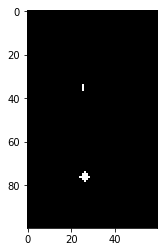

In [5]:
print(np.sum(env.initial_food[30:40, 20:30]))

plt.imshow(env.initial_food)
plt.show()

(100, 60)
(10, 20, 7)
(10, 20, 7)
(10, 20, 7)
(10, 20, 7)
(100, 60, 7)
(10, 20, 7)
(10, 20, 7)
(10, 20, 7)
(10, 20, 7)
(10, 20, 7)
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 100, 60])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
torch.Size([1, 7, 10, 20])
100
60
[(35, 24), (22, 39), (35, 27), (36, 25), (33, 25), (22, 21), (34, 25), (20, 21), (35, 25), (74, 39)]
['Vikings', 'Franks']
[0, 0, 0, 0, None, 0, 0, 0, 0, 0]
(10, 20, 7)


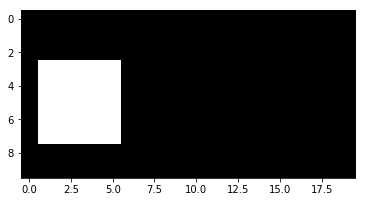

(10, 20, 7)


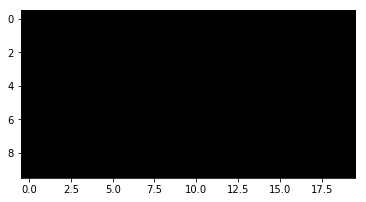

(10, 20, 7)


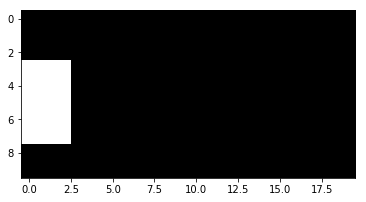

(10, 20, 7)


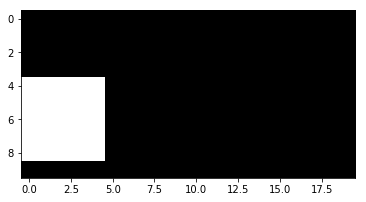

(100, 60, 7)


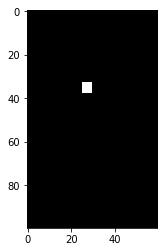

(10, 20, 7)


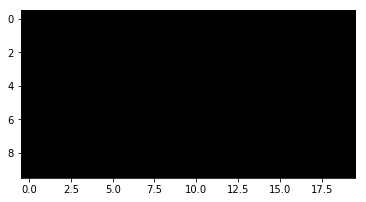

(10, 20, 7)


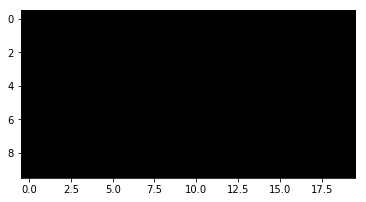

(10, 20, 7)


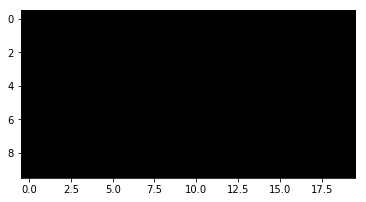

(10, 20, 7)


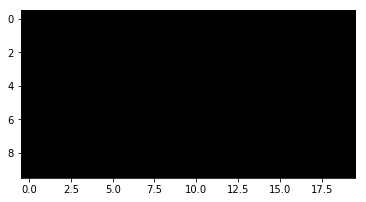

(10, 20, 7)


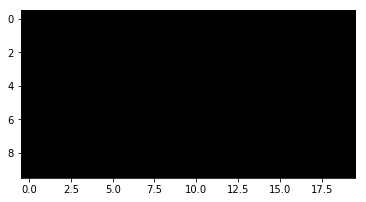

In [6]:
print(env.food.shape)
for obs in env_obs:
    print(obs.shape)
for obs in agents_obs:
    print(obs.shape)
print(env.gamespace_width)
print(env.gamespace_height)
print(env.agent_locations)
print(env.teams)
print(env.tagged)

for state in env.state_n:
    print(state.shape)
    plt.imshow(state[:,:,6])
    plt.show()

In [7]:
for team in teams_params:
    print ("Team {}".format(team['name']) )
    for k, v in team.items():
        print (k, v)
    print ('\n')

for i, agent in enumerate(agents_params):
    print ("Agent {}".format(agent['id']) )
    for k, v in agent.items():
        print (k, v)
    print (env.agent_locations[i])
    print ('\n')


Team Vikings
name Vikings
color deepskyblue
culture {'name': 'pacifist_leadfollow', 'laser_penalty': -1.0, 'target_reward': 2.0}
roles ['leader', 'follower']
target_zone None
banned_zone None


Team Franks
name Franks
color red
culture {'name': 'pacifist', 'laser_penalty': -1.0}
roles ['leader', 'follower']
target_zone None
banned_zone None


Agent 0
id 0
team Vikings
color deepskyblue
type crawler
role follower
start (1, 7)
(35, 24)


Agent 1
id 1
team Vikings
color deepskyblue
type crawler
role follower
start (1, 9)
(22, 39)


Agent 2
id 2
team Vikings
color deepskyblue
type crawler
role follower
start (2, 8)
(35, 27)


Agent 3
id 3
team Vikings
color deepskyblue
type crawler
role follower
start (3, 7)
(36, 25)


Agent 4
id 4
team Vikings
color royalblue
type drone
role leader
start (3, 9)
(33, 25)


Agent 5
id 5
team Franks
color red
type crawler
role follower
start (1, 1)
(22, 21)


Agent 6
id 6
team Franks
color red
type crawler
role follower
start (1, 3)
(34, 25)


Agent 7
id 7
t

## Training - DroneLeader_PG

In [4]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-1L/pg_droneleader_2000/'    # 1 team of 1 policy gradient based drone leader 

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
]

temp_end = 1.2   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 2000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 10
save_interval = 20

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-2

# Initialize agents parameters
#   1 agents - 1 learning agents, 0 trained agent, 0 random agent
num_learners = 1
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    torch.manual_seed(parameter['seed'])
    situation = 'pg_droneleader_seed_'+str(parameter['seed'])
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    deltas = []   # 6-2-2019 delta coordinates
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(Drone_Policy(num_frames, num_drone_actions, i))  
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]
        deltas = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # 6-2-2019 Keep track of distance from goal achieved by droneleader
        episode_delta = 0   # distance from goal for an episode
        running_delta = None   # running distance from goal
        running_deltas = []    # history of running distance from goal
        best_delta = 0    # best running distance from goal (for storing best_model)        
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
        # agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        episode_delta = 0                               # distance from goal for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
            # agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
        
        # 6-02-2019 Update distance from goal for droneleader
        target_x, target_y = goals[0]
        current_x, current_y = env.agent_locations[0]
        episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
        
        if running_delta is None:
            running_delta = episode_delta
        running_delta = running_delta * 0.99 + episode_delta * 0.01
        running_deltas.append(running_delta)
        
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                # verbose_str = 'Learner:{}'.format(i)
                # verbose_str += '\tReward total:{}'.format(episode_reward[i])
                # verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                # verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                # verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                verbose_str += '\tDelta total:{}'.format(episode_delta)
                verbose_str += '\tRunning mean: {:.4}'.format(running_delta)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)

            delta_file = results_dir+'/{}/t{}_rp{}_{}gs/Delta.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(delta_file), exist_ok=True)
            with open(delta_file, 'wb') as f:
                    pickle.dump(running_deltas, f)

    end = time.clock()
    print('\nTraining time: {:.2f} sec'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
..........
Episode 10 complete

Episode 10 complete	Delta total:7	Running mean: 54.54
Max Norms =  ['139.23']
..........
Episode 20 complete

Episode 20 complete	Delta total:7	Running mean: 50.96
Max Norms =  ['89.19']
..........
Episode 30 complete

Episode 30 complete	Delta total:37	Running mean: 47.29
Max Norms =  ['108.86']
..........
Episode 40 complete

Episode 40 complete	Delta total:45	Running mean: 46.56
Max Norms =  ['120.65']
..........
Episode 50 complete

Episode 50 complete	Delta total:44	Running mean: 46.09
Max Norms =  ['78.81']
..........
Episode 60 complete

Episode 60 complete	Delta total:43	Running mean: 45.72
Max Norms =  ['74.12']
..........
Episode 70 complete

Episode 70 complete	Delta total:42	Running mean: 45.27
Max Norms =  ['128.72']
..........
Episode 80 complete

Episode 80 complete	Delta total:43	Running mean: 44.97
Max Norms =  ['51.43']
..........
Episode 90 complete

Episode 90 complete	Delta total:43	Running mean: 44

..........
Episode 750 complete

Episode 750 complete	Delta total:42	Running mean: 40.95
Max Norms =  ['0.57']
..........
Episode 760 complete

Episode 760 complete	Delta total:43	Running mean: 41.11
Max Norms =  ['14.20']
..........
Episode 770 complete

Episode 770 complete	Delta total:44	Running mean: 41.38
Max Norms =  ['12.17']
..........
Episode 780 complete

Episode 780 complete	Delta total:44	Running mean: 41.63
Max Norms =  ['8.32']
..........
Episode 790 complete

Episode 790 complete	Delta total:44	Running mean: 41.86
Max Norms =  ['84.17']
..........
Episode 800 complete

Episode 800 complete	Delta total:45	Running mean: 42.15
Max Norms =  ['36.75']
..........
Episode 810 complete

Episode 810 complete	Delta total:45	Running mean: 42.42
Max Norms =  ['2.01']
..........
Episode 820 complete

Episode 820 complete	Delta total:44	Running mean: 42.58
Max Norms =  ['1.73']
..........
Episode 830 complete

Episode 830 complete	Delta total:44	Running mean: 42.7
Max Norms =  ['5.93'

..........
Episode 1480 complete

Episode 1480 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.01']
..........
Episode 1490 complete

Episode 1490 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.01']
..........
Episode 1500 complete

Episode 1500 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.01']
..........
Episode 1510 complete

Episode 1510 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.01']
..........
Episode 1520 complete

Episode 1520 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.01']
..........
Episode 1530 complete

Episode 1530 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.01']
..........
Episode 1540 complete

Episode 1540 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.00']
..........
Episode 1550 complete

Episode 1550 complete	Delta total:43	Running mean: 43.0
Max Norms =  ['0.00']
..........
Episode 1560 complete

Episode 1560 complete	Delta total:43	Running mean: 43.0
Max Norms =  [

In [35]:
agents[0].apples_hist

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

# Train Agents with New Env

The code below run training on 2 teams of 5 Agents each using the new environment.

Team Viking has a Pacifist culture and they are unagressive (do not fire their lasers). Team Franks has a Cooperative culture and their agents specialize into 'shooters' and 'gatherers' even though these roles are not formally defined. Thus the Team Viking is highly disadvantaged in this situation. 

We will investigate how the introduction of a 'leader' can change the dynamic of this game.

In [3]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
experiment = '2T-5L/pac_droneleader/'    # 2 team of 5 agents; a team of pacifist with a drone leader 

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300}
            ]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 3000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 20
save_interval = 50

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3

# Initialize agents parameters
#   10 agents - 10 learning agents, 0 trained agent, 0 random agent
num_learners = 10
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  
       

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    situation = 'pac_vs_pac_apples_teamreward'
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
        {'name': 'Franks', 'color': 'red', 
         'culture': {'name':'pacifist','laser_penalty':-1.0},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None}
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',     \
         'role': 'follower', 'start': (1,7)},  # Use a different color for Leader
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9)},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8)},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7)},
        # Leader of Team Viking is a drone and has a different color
        {'id': 4, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
        {'id': 5, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,1)},
        {'id': 6, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,3)},
        {'id': 7, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,2)},
        {'id': 8, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,1)},
        {'id': 9, 'team': 'Franks', 'color': teams_params[1]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,3)}
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0], agents[1], agents[2], agents[3], agents[4]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:5]]))
    # Team Franks
    teams.append(Team(name=teams_params[1]['name'],color=teams_params[1]['color'], \
                  culture=teams_params[1]['culture'], roles=teams_params[1]['roles'], \
                  agent_policies=[agents[5], agents[6], agents[7], agents[8], agents[9]], \
                  agent_roles = [agent['role'] for agent in agents_params[5:10]]))
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_agent=0)   

    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode

    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)
    
    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Learner agent 8
Learner agent 9
....................
Episode 20 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.02504	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:5	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:6	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:7	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:8	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:9	Reward total:0	Running mean: 0.00951	N

....................
Episode 180 complete
Learner:0	Reward total:4	Running mean: 0.2804	Num agents crossed: 0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.1489	Num agents crossed: 0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.05688	Num agents crossed: 0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.06421	Num agents crossed: 0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0
Learner:5	Reward total:7	Running mean: 0.2042	Num agents crossed: 0	Running mean: 0.0
Learner:6	Reward total:0	Running mean: 0.1106	Num agents crossed: 0	Running mean: 0.0
Learner:7	Reward total:0	Running mean: -0.006328	Num agents crossed: 0	Running mean: 0.0
Learner:8	Reward total:0	Running mean: 0.07255	Num agents crossed: 0	Running mean: 0.0
Learner:9	Reward total:0	Running mean: 0.2038	Num agents crossed: 0	Running mean: 0.0
Max Norms =  ['113.33', '0.00', '103.13', '94.92', '198.36', '133.99', '0.00', '0.00', '0.00', 

....................
Episode 340 complete
Learner:0	Reward total:0	Running mean: 1.343	Num agents crossed: 0	Running mean: 0.2354
Learner:1	Reward total:7	Running mean: 2.863	Num agents crossed: 0	Running mean: 0.2354
Learner:2	Reward total:-8.0	Running mean: 2.602	Num agents crossed: 0	Running mean: 0.2354
Learner:3	Reward total:6	Running mean: -0.2264	Num agents crossed: 0	Running mean: 0.2354
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.2354
Learner:5	Reward total:7	Running mean: 0.8488	Num agents crossed: 0	Running mean: 0.2354
Learner:6	Reward total:0	Running mean: 0.07118	Num agents crossed: 0	Running mean: 0.2354
Learner:7	Reward total:2	Running mean: 0.3094	Num agents crossed: 0	Running mean: 0.2354
Learner:8	Reward total:0	Running mean: 0.09363	Num agents crossed: 0	Running mean: 0.2354
Learner:9	Reward total:0	Running mean: 0.5233	Num agents crossed: 0	Running mean: 0.2354
Max Norms =  ['0.00', '140.21', '138.56', '121.57', '233.42', '110.6

....................
Episode 500 complete
Learner:0	Reward total:6	Running mean: 4.235	Num agents crossed: 0	Running mean: 0.41
Learner:1	Reward total:5	Running mean: 2.991	Num agents crossed: 0	Running mean: 0.41
Learner:2	Reward total:9	Running mean: 5.877	Num agents crossed: 0	Running mean: 0.41
Learner:3	Reward total:2	Running mean: 4.633	Num agents crossed: 0	Running mean: 0.41
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.41
Learner:5	Reward total:3	Running mean: 1.565	Num agents crossed: 0	Running mean: 0.41
Learner:6	Reward total:0	Running mean: 0.03516	Num agents crossed: 0	Running mean: 0.41
Learner:7	Reward total:12	Running mean: 8.076	Num agents crossed: 0	Running mean: 0.41
Learner:8	Reward total:0	Running mean: -0.1751	Num agents crossed: 0	Running mean: 0.41
Learner:9	Reward total:0.0	Running mean: 1.92	Num agents crossed: 0	Running mean: 0.41
Max Norms =  ['127.59', '115.55', '133.68', '74.55', '168.11', '122.32', '0.00', '62.04', '0.0

....................
Episode 660 complete
Learner:0	Reward total:9	Running mean: 5.078	Num agents crossed: 1	Running mean: 0.4745
Learner:1	Reward total:7	Running mean: 3.095	Num agents crossed: 1	Running mean: 0.4745
Learner:2	Reward total:5	Running mean: 5.383	Num agents crossed: 1	Running mean: 0.4745
Learner:3	Reward total:5	Running mean: 4.206	Num agents crossed: 1	Running mean: 0.4745
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.4745
Learner:5	Reward total:4	Running mean: 2.829	Num agents crossed: 1	Running mean: 0.4745
Learner:6	Reward total:0	Running mean: 0.05767	Num agents crossed: 1	Running mean: 0.4745
Learner:7	Reward total:14	Running mean: 18.78	Num agents crossed: 1	Running mean: 0.4745
Learner:8	Reward total:2	Running mean: -0.1497	Num agents crossed: 1	Running mean: 0.4745
Learner:9	Reward total:14.0	Running mean: 10.58	Num agents crossed: 1	Running mean: 0.4745
Max Norms =  ['96.06', '75.18', '97.51', '60.33', '169.71', '128.83', '0

....................
Episode 820 complete
Learner:0	Reward total:4	Running mean: 5.321	Num agents crossed: 1	Running mean: 0.9992
Learner:1	Reward total:8	Running mean: 2.688	Num agents crossed: 1	Running mean: 0.9992
Learner:2	Reward total:5	Running mean: 4.534	Num agents crossed: 1	Running mean: 0.9992
Learner:3	Reward total:0	Running mean: 4.405	Num agents crossed: 1	Running mean: 0.9992
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.9992
Learner:5	Reward total:2	Running mean: 4.919	Num agents crossed: 1	Running mean: 0.9992
Learner:6	Reward total:0	Running mean: 0.9429	Num agents crossed: 1	Running mean: 0.9992
Learner:7	Reward total:27	Running mean: 21.08	Num agents crossed: 1	Running mean: 0.9992
Learner:8	Reward total:0	Running mean: -0.2763	Num agents crossed: 1	Running mean: 0.9992
Learner:9	Reward total:73.0	Running mean: 40.18	Num agents crossed: 1	Running mean: 0.9992
Max Norms =  ['191.02', '99.42', '128.86', '58.09', '205.43', '98.94', '0

....................
Episode 980 complete
Learner:0	Reward total:5	Running mean: 3.973	Num agents crossed: 2	Running mean: 1.307
Learner:1	Reward total:8	Running mean: 3.295	Num agents crossed: 2	Running mean: 1.307
Learner:2	Reward total:6	Running mean: 3.283	Num agents crossed: 2	Running mean: 1.307
Learner:3	Reward total:2	Running mean: 3.216	Num agents crossed: 2	Running mean: 1.307
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 2	Running mean: 1.307
Learner:5	Reward total:3	Running mean: 8.12	Num agents crossed: 2	Running mean: 1.307
Learner:6	Reward total:12.0	Running mean: 6.733	Num agents crossed: 2	Running mean: 1.307
Learner:7	Reward total:20	Running mean: 20.16	Num agents crossed: 2	Running mean: 1.307
Learner:8	Reward total:0	Running mean: 0.3057	Num agents crossed: 2	Running mean: 1.307
Learner:9	Reward total:91.0	Running mean: 61.81	Num agents crossed: 2	Running mean: 1.307
Max Norms =  ['107.67', '82.81', '89.21', '48.80', '206.10', '74.20', '99.84', '43.

....................
Episode 1140 complete
Learner:0	Reward total:0	Running mean: 1.649	Num agents crossed: 1	Running mean: 1.219
Learner:1	Reward total:0	Running mean: 1.875	Num agents crossed: 1	Running mean: 1.219
Learner:2	Reward total:0	Running mean: 1.402	Num agents crossed: 1	Running mean: 1.219
Learner:3	Reward total:1	Running mean: 1.569	Num agents crossed: 1	Running mean: 1.219
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 1.219
Learner:5	Reward total:3	Running mean: 7.383	Num agents crossed: 1	Running mean: 1.219
Learner:6	Reward total:1	Running mean: 8.969	Num agents crossed: 1	Running mean: 1.219
Learner:7	Reward total:40	Running mean: 20.33	Num agents crossed: 1	Running mean: 1.219
Learner:8	Reward total:5	Running mean: 6.673	Num agents crossed: 1	Running mean: 1.219
Learner:9	Reward total:93.0	Running mean: 69.32	Num agents crossed: 1	Running mean: 1.219
Max Norms =  ['64.11', '51.16', '82.94', '150.75', '143.84', '110.06', '127.52', '12.

Max Norms =  ['34.83', '92.20', '37.51', '29.80', '227.36', '122.80', '0.00', '26.93', '1.29', '214.08']
....................
Episode 1480 complete
Learner:0	Reward total:0	Running mean: 0.8161	Num agents crossed: 1	Running mean: 1.222
Learner:1	Reward total:1	Running mean: 0.9664	Num agents crossed: 1	Running mean: 1.222
Learner:2	Reward total:1	Running mean: 0.8836	Num agents crossed: 1	Running mean: 1.222
Learner:3	Reward total:0	Running mean: 0.8654	Num agents crossed: 1	Running mean: 1.222
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 1.222
Learner:5	Reward total:5	Running mean: 11.81	Num agents crossed: 1	Running mean: 1.222
Learner:6	Reward total:0	Running mean: 7.272	Num agents crossed: 1	Running mean: 1.222
Learner:7	Reward total:17	Running mean: 16.71	Num agents crossed: 1	Running mean: 1.222
Learner:8	Reward total:17	Running mean: 15.07	Num agents crossed: 1	Running mean: 1.222
Learner:9	Reward total:100.0	Running mean: 91.17	Num agents cross

Max Norms =  ['10.27', '68.69', '26.15', '3.22', '123.51', '122.15', '0.00', '1.88', '2.41', '201.12']
....................
Episode 1640 complete
Learner:0	Reward total:0	Running mean: 0.4633	Num agents crossed: 2	Running mean: 1.151
Learner:1	Reward total:0	Running mean: 1.173	Num agents crossed: 2	Running mean: 1.151
Learner:2	Reward total:0	Running mean: 0.6447	Num agents crossed: 2	Running mean: 1.151
Learner:3	Reward total:0	Running mean: 0.5185	Num agents crossed: 2	Running mean: 1.151
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 2	Running mean: 1.151
Learner:5	Reward total:40.0	Running mean: 10.69	Num agents crossed: 2	Running mean: 1.151
Learner:6	Reward total:0	Running mean: 5.453	Num agents crossed: 2	Running mean: 1.151
Learner:7	Reward total:17	Running mean: 15.37	Num agents crossed: 2	Running mean: 1.151
Learner:8	Reward total:17	Running mean: 15.97	Num agents crossed: 2	Running mean: 1.151
Learner:9	Reward total:73.0	Running mean: 95.79	Num agents crosse

Max Norms =  ['18.56', '124.74', '45.21', '1.09', '187.27', '18.57', '0.00', '0.00', '0.16', '73.28']
....................
Episode 1800 complete
Learner:0	Reward total:0	Running mean: 0.3475	Num agents crossed: 1	Running mean: 0.9798
Learner:1	Reward total:2	Running mean: 0.9542	Num agents crossed: 1	Running mean: 0.9798
Learner:2	Reward total:0	Running mean: 3.809	Num agents crossed: 1	Running mean: 0.9798
Learner:3	Reward total:0	Running mean: 0.1038	Num agents crossed: 1	Running mean: 0.9798
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.9798
Learner:5	Reward total:0	Running mean: 8.781	Num agents crossed: 1	Running mean: 0.9798
Learner:6	Reward total:0	Running mean: 1.557	Num agents crossed: 1	Running mean: 0.9798
Learner:7	Reward total:17	Running mean: 13.81	Num agents crossed: 1	Running mean: 0.9798
Learner:8	Reward total:17	Running mean: 16.86	Num agents crossed: 1	Running mean: 0.9798
Learner:9	Reward total:121.0	Running mean: 83.4	Num agents c

Max Norms =  ['26.12', '100.24', '194.01', '18.40', '39.50', '0.00', '0.00', '0.51', '0.09', '147.54']
....................
Episode 1960 complete
Learner:0	Reward total:1	Running mean: 0.4158	Num agents crossed: 1	Running mean: 0.9927
Learner:1	Reward total:1	Running mean: 1.141	Num agents crossed: 1	Running mean: 0.9927
Learner:2	Reward total:1	Running mean: 4.846	Num agents crossed: 1	Running mean: 0.9927
Learner:3	Reward total:0	Running mean: 0.0208	Num agents crossed: 1	Running mean: 0.9927
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.9927
Learner:5	Reward total:0	Running mean: 5.028	Num agents crossed: 1	Running mean: 0.9927
Learner:6	Reward total:0	Running mean: 0.5629	Num agents crossed: 1	Running mean: 0.9927
Learner:7	Reward total:17	Running mean: 14.81	Num agents crossed: 1	Running mean: 0.9927
Learner:8	Reward total:17	Running mean: 16.88	Num agents crossed: 1	Running mean: 0.9927
Learner:9	Reward total:115.0	Running mean: 103.3	Num agents

Max Norms =  ['70.96', '132.73', '49.55', '38.53', '94.45', '0.00', '17.68', '0.66', '2.75', '105.52']
....................
Episode 2120 complete
Learner:0	Reward total:0	Running mean: 0.09168	Num agents crossed: 1	Running mean: 0.9912
Learner:1	Reward total:0	Running mean: 0.4902	Num agents crossed: 1	Running mean: 0.9912
Learner:2	Reward total:0	Running mean: 1.143	Num agents crossed: 1	Running mean: 0.9912
Learner:3	Reward total:0	Running mean: 0.09389	Num agents crossed: 1	Running mean: 0.9912
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.9912
Learner:5	Reward total:17	Running mean: 9.781	Num agents crossed: 1	Running mean: 0.9912
Learner:6	Reward total:0	Running mean: 0.8202	Num agents crossed: 1	Running mean: 0.9912
Learner:7	Reward total:17	Running mean: 15.79	Num agents crossed: 1	Running mean: 0.9912
Learner:8	Reward total:17	Running mean: 16.85	Num agents crossed: 1	Running mean: 0.9912
Learner:9	Reward total:127.0	Running mean: 114.3	Num ag

Max Norms =  ['44.81', '98.25', '17.60', '97.85', '71.56', '31.59', '0.00', '0.22', '0.07', '47.23']
....................
Episode 2280 complete
Learner:0	Reward total:0	Running mean: 0.01836	Num agents crossed: 1	Running mean: 1.003
Learner:1	Reward total:0	Running mean: -1.123	Num agents crossed: 1	Running mean: 1.003
Learner:2	Reward total:0	Running mean: 0.2457	Num agents crossed: 1	Running mean: 1.003
Learner:3	Reward total:0	Running mean: 0.07097	Num agents crossed: 1	Running mean: 1.003
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 1.003
Learner:5	Reward total:17	Running mean: 14.42	Num agents crossed: 1	Running mean: 1.003
Learner:6	Reward total:0	Running mean: 1.22	Num agents crossed: 1	Running mean: 1.003
Learner:7	Reward total:17	Running mean: 16.27	Num agents crossed: 1	Running mean: 1.003
Learner:8	Reward total:17	Running mean: 16.94	Num agents crossed: 1	Running mean: 1.003
Learner:9	Reward total:112.0	Running mean: 104.8	Num agents crossed

Max Norms =  ['15.82', '52.70', '120.61', '0.61', '24.02', '9.26', '0.00', '0.53', '0.03', '501.05']
....................
Episode 2440 complete
Learner:0	Reward total:0	Running mean: 0.1333	Num agents crossed: 1	Running mean: 1.054
Learner:1	Reward total:0	Running mean: -0.2201	Num agents crossed: 1	Running mean: 1.054
Learner:2	Reward total:0	Running mean: 0.1031	Num agents crossed: 1	Running mean: 1.054
Learner:3	Reward total:0	Running mean: -0.003291	Num agents crossed: 1	Running mean: 1.054
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 1.054
Learner:5	Reward total:17	Running mean: 15.05	Num agents crossed: 1	Running mean: 1.054
Learner:6	Reward total:0	Running mean: 1.002	Num agents crossed: 1	Running mean: 1.054
Learner:7	Reward total:17	Running mean: 16.73	Num agents crossed: 1	Running mean: 1.054
Learner:8	Reward total:17	Running mean: 17.02	Num agents crossed: 1	Running mean: 1.054
Learner:9	Reward total:137.0	Running mean: 117.4	Num agents cros

Max Norms =  ['46.02', '86.62', '3.46', '82.89', '11.35', '25.69', '80.51', '0.20', '0.02', '66.02']
....................
Episode 2600 complete
Learner:0	Reward total:0	Running mean: 0.03777	Num agents crossed: 1	Running mean: 1.278
Learner:1	Reward total:0	Running mean: 0.07711	Num agents crossed: 1	Running mean: 1.278
Learner:2	Reward total:0	Running mean: 0.02065	Num agents crossed: 1	Running mean: 1.278
Learner:3	Reward total:0	Running mean: -0.06752	Num agents crossed: 1	Running mean: 1.278
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 1.278
Learner:5	Reward total:17	Running mean: 15.78	Num agents crossed: 1	Running mean: 1.278
Learner:6	Reward total:0	Running mean: 4.391	Num agents crossed: 1	Running mean: 1.278
Learner:7	Reward total:17	Running mean: 16.86	Num agents crossed: 1	Running mean: 1.278
Learner:8	Reward total:17	Running mean: 16.42	Num agents crossed: 1	Running mean: 1.278
Learner:9	Reward total:124.0	Running mean: 115.7	Num agents cro

Max Norms =  ['14.83', '24.19', '0.09', '0.33', '9.37', '15.36', '0.00', '0.06', '0.01', '45.99']
....................
Episode 2760 complete
Learner:0	Reward total:0	Running mean: 0.03314	Num agents crossed: 1	Running mean: 1.075
Learner:1	Reward total:0	Running mean: 0.002462	Num agents crossed: 1	Running mean: 1.075
Learner:2	Reward total:0	Running mean: 0.004136	Num agents crossed: 1	Running mean: 1.075
Learner:3	Reward total:0	Running mean: -0.01352	Num agents crossed: 1	Running mean: 1.075
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 1.075
Learner:5	Reward total:17	Running mean: 16.52	Num agents crossed: 1	Running mean: 1.075
Learner:6	Reward total:0	Running mean: 1.382	Num agents crossed: 1	Running mean: 1.075
Learner:7	Reward total:17	Running mean: 17.09	Num agents crossed: 1	Running mean: 1.075
Learner:8	Reward total:17	Running mean: 17.08	Num agents crossed: 1	Running mean: 1.075
Learner:9	Reward total:137.0	Running mean: 127.9	Num agents cros

Max Norms =  ['1.52', '63.34', '0.04', '0.22', '15.06', '7.76', '0.00', '0.03', '0.01', '27.56']
....................
Episode 2920 complete
Learner:0	Reward total:0	Running mean: 0.006637	Num agents crossed: 1	Running mean: 0.9864
Learner:1	Reward total:0	Running mean: 0.0004932	Num agents crossed: 1	Running mean: 0.9864
Learner:2	Reward total:0	Running mean: 0.0008283	Num agents crossed: 1	Running mean: 0.9864
Learner:3	Reward total:0	Running mean: -0.002708	Num agents crossed: 1	Running mean: 0.9864
Learner:4	Reward total:0	Running mean: 0.0	Num agents crossed: 1	Running mean: 0.9864
Learner:5	Reward total:17	Running mean: 16.55	Num agents crossed: 1	Running mean: 0.9864
Learner:6	Reward total:0	Running mean: 0.2768	Num agents crossed: 1	Running mean: 0.9864
Learner:7	Reward total:17	Running mean: 17.03	Num agents crossed: 1	Running mean: 0.9864
Learner:8	Reward total:17	Running mean: 17.05	Num agents crossed: 1	Running mean: 0.9864
Learner:9	Reward total:137.0	Running mean: 130.6	Nu

In [8]:
print (teams[0].culture)
print (teams[1].culture)
print (agents)
print ([agent.type for agent in agents])
print (actions)


{'name': 'pacifist_leadfollow', 'laser_penalty': -1.0, 'target_reward': 2.0}
{'name': 'pacifist', 'laser_penalty': -1.0}
[Crawler_Policy(
  (features): Sequential(
    (0): Conv2d(7, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
  )
  (action_head): Linear(in_features=384, out_features=8, bias=True)
), Crawler_Policy(
  (features): Sequential(
    (0): Conv2d(7, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReL

In [3]:
env.close()